## Importación de librerías

In [1]:
# Manipulación de datos
import numpy as np
import pandas as pd
import math

# Estadística y normalización
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import data_utils as du

## Carga de datos

In [2]:
df = pd.read_csv('../data/motor_data_2011_2018_EDA.csv')

df.head()

,OBJECT_ID,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
0,5000029885,0,2013-08-08,2014-08-07,2008.0,1202,519755.22,7209.140,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
1,5000029885,0,2012-08-08,2013-08-07,2008.0,1202,519755.22,7203.890,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
2,5000029885,0,2011-08-08,2012-08-07,2008.0,1202,519755.22,7045.804,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
3,5000029885,0,2011-07-08,2011-08-07,2008.0,1202,519755.22,287.250,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
4,5000029901,0,2013-08-08,2014-08-07,2008.0,1202,285451.24,4286.900,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43


## Gestión de nulos

In [3]:
# Identificar todas las columnas numéricas del DataFrame
num_cols = df.select_dtypes(include='number').columns

# Identificación de valores nulos en el DataFrame
cantidad_nulos = df.isna().sum()  # Suma valores nulos por columna
cantidad_nulos = cantidad_nulos[cantidad_nulos != 0]  # Filtra solo columnas con valores nulos

cantidad_nulos  # Muestra el resultado

EFFECTIVE_YR           1171
PREMIUM                  21
PROD_YEAR               169
SEATS_NUM               235
CARRYING_CAPACITY    198162
CCM_TON                   8
MAKE                      5
CLAIM_PAID           741693
dtype: int64

## Imputación de valores nulos

- **Variables categóricas**  
  Se sustituyen los valores faltantes por la categoría genérica **`"Unknown"`**, asegurando que ninguna etiqueta válida se vea desplazada y permitiendo identificar explícitamente la ausencia de dato.

- **Variables numéricas**  
  Usaremos la función imputar_nulos_por_distribucion del módulo data_utils
  que realiza la imputación de valores nulos basándose en la distribución de los datos. 


> Esta estrategia de imputación mantiene la integridad del dataset y aplica un tratamiento adaptado al tipo de variable, sin necesidad de eliminar filas con información parcial.  

In [4]:
# Imputación de valores nulos en columnas numéricas
#  ----------------------------------------------------------------

# CLAIM_PAID tiene 0s y NaNs, los NaNs indican que no hubo reclamación
# Vamos a imputar los NaNs con 0 y crear una nueva columna HAS_CLAIM 
# que indique si hubo una reclamación o no.
# Completamos CLAIM_PAID con 0 y creamos HAS_CLAIM
df['CLAIM_PAID'] = df['CLAIM_PAID'].fillna(0)
df['HAS_CLAIM'] = np.where(df['CLAIM_PAID'] > 0, 1, 0)

# Filtramos columnas a imputar (excluimos CLAIM_PAID, ya imputado)
columnas_a_imputar = [col for col in df.columns if col != 'CLAIM_PAID']

# Imputamos
df = du.imputar_nulos_por_distribucion(df, columnas_a_imputar)

# Verificamos nulos restantes
print("\nNulos restantes después de imputar:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Asimetría (skewness) de 'EFFECTIVE_YR': 2.706
Media    de 'EFFECTIVE_YR': 2019.844
Mediana  de 'EFFECTIVE_YR': 2013.000
Moda     de 'EFFECTIVE_YR': 2011.0
Distribución asimétrica (|skew| ≥ 0.5), imputando con moda.

Asimetría (skewness) de 'PREMIUM': 220.504
Media    de 'PREMIUM': 7407.881
Mediana  de 'PREMIUM': 3378.170
Moda     de 'PREMIUM': 347.7
Distribución asimétrica (|skew| ≥ 0.5), imputando con moda.

Asimetría (skewness) de 'PROD_YEAR': -1.169
Media    de 'PROD_YEAR': 2004.534
Mediana  de 'PROD_YEAR': 2008.000
Moda     de 'PROD_YEAR': 2012.0
Distribución asimétrica (|skew| ≥ 0.5), imputando con moda.

Asimetría (skewness) de 'SEATS_NUM': 6.595
Media    de 'SEATS_NUM': 6.130
Mediana  de 'SEATS_NUM': 4.000
Moda     de 'SEATS_NUM': 4.0
Distribución asimétrica (|skew| ≥ 0.5), imputando con moda.

Asimetría (skewness) de 'CARRYING_CAPACITY': 39.458
Media    de 'CARRYING_CAPACITY': 497.998
Mediana  de 'CARRYING_CAPACITY': 6.000
Moda     de 'CARRYING_CAPACITY': 0.0
Distribución asimé

In [5]:
# # Análisis de valores únicos en columnas categóricas con valores nulos
# ----------------------------------------------------------------
# Identificar todas las columnas categóricas
cat_cols = df.select_dtypes(include='object').columns

# Filtrar solo las categóricas que tienen nulos
cat_nulls = [col for col in cat_cols if df[col].isna().sum() > 0]

# Crear variables indicadoras para cada una
for col in cat_nulls:
    df[f"{col}_missing"] = df[col].isna().astype(int)
# mostrar las columnas que tienen valores nulos
df[cat_nulls].isna().sum()

Series([], dtype: float64)

In [6]:
# Normalizar la columna categórica 'MAKE'
#  ----------------------------------------------------------------

# 1️⃣ Normalizar texto: mayúsculas, eliminar espacios extremos
df['MAKE'] = df['MAKE'].str.upper().str.strip()

# 2️⃣ Reemplazos manuales para corregir inconsistencias conocidas
reemplazos = {
    'TOYOTA JAPAN': 'TOYOTA',
    # Puedes añadir más casos aquí si detectas otros errores
}

df['MAKE'] = df['MAKE'].replace(reemplazos)

# 3️⃣ Agrupar marcas poco frecuentes en 'OTRAS'
umbral = 0.01 * len(df)  # Marcas que representan menos del 1% de los registros
marcas_frecuentes = df['MAKE'].value_counts()[df['MAKE'].value_counts() > umbral].index

df['MAKE'] = df['MAKE'].apply(lambda x: x if x in marcas_frecuentes else 'OTRAS')

# 4️⃣ Mostrar resultado final
print("\nListado de marcas finales:")
print(df['MAKE'].value_counts())




Listado de marcas finales:
MAKE
TOYOTA        272628
OTRAS         192759
ISUZU          75661
BAJAJI         67320
NISSAN         37183
MITSUBISHI     22093
IVECO          20439
BAJAJ          17917
SINO HOWO      17024
YAMAHA         15743
SUZUKI         13061
FIAT           12902
BISHOFTU       12515
TVS            12405
MESFIN         12188
Name: count, dtype: int64


In [7]:
# Comprobación de nulos
df.isna().sum().sum()

np.int64(0)

## Gestión outliers

### Identificación de outliers mediante boxplot

/var/folders/s8/l3j5zms14s71b3h4v6d7qkl00000gn/T/ipykernel_2305/3560430413.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/s8/l3j5zms14s71b3h4v6d7qkl00000gn/T/ipykernel_2305/3560430413.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/s8/l3j5zms14s71b3h4v6d7qkl00000gn/T/ipykernel_2305/3560430413.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/s8/l3j5zms14s71b3h4v6d7qkl00000gn/T/ipykernel_2305/3560430413.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

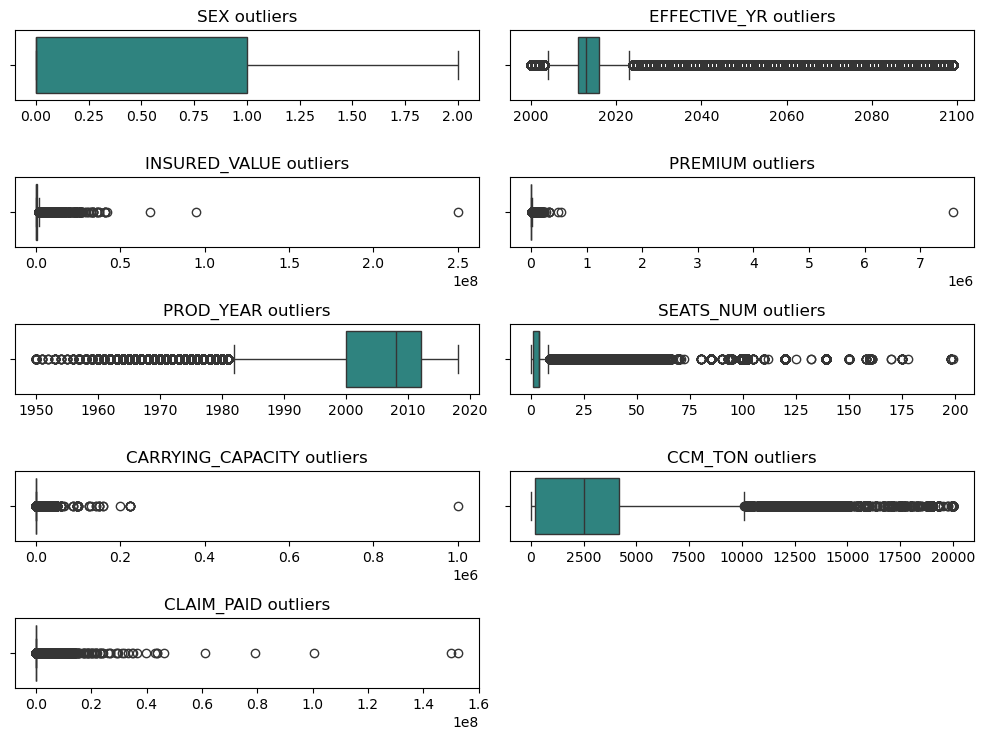

In [8]:
# Visualización de outliers en variables numéricas mediante diagramas de caja

# Seleccionar solo columnas numéricas del DataFrame
# Seleccionamos solo las columnas numéricas, excluyendo HAS_CLAIM, OBJECT_ID por ser clave y
# INSR_TYPE por ser categorica a pesar de ser numérica
df_num = df.select_dtypes(include=np.number).drop(columns=['HAS_CLAIM', 'OBJECT_ID', 'INSR_TYPE'], errors='ignore')
cols_num = df_num.columns

# Calcular el número de gráficos y filas necesarias
n_plots = len(cols_num)
num_rows = math.ceil(n_plots / 2)  # Se distribuyen en 2 columnas

# Ajustar dinámicamente el tamaño de la figura
width = 5 * 2
height = 1.5 * num_rows
size = (width, height)

# Crear la estructura de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=size)
axes = axes.flat  # Convertir matriz de ejes a lista plana

# Crear un boxplot para cada variable numérica
for i, col in enumerate(cols_num):
   sns.boxplot(
       x=col,
       data=df_num,
       palette="viridis",
       ax=axes[i]
   )

   axes[i].set_title(f'{col} outliers')
   axes[i].set_xlabel('')  # Eliminar etiqueta del eje x para mayor claridad

# Eliminar el último gráfico si sobra un espacio vacío
if n_plots % 2 != 0:
   fig.delaxes(axes[-1])

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()


✅ Código para detección y almacenamiento de outliers listos para imputación

In [9]:
# Diccionario para almacenar los índices de los outliers detectados en cada columna
outliers_indices_dict = {}

# Iterar sobre cada columna numérica
for col in df_num.columns:
    
    # Calcular cuartiles
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites para considerar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Índices de outliers
    outlier_indices = df_num[(df_num[col] < lower_bound) | (df_num[col] > upper_bound)].index.tolist()
    
    # Guardamos los índices de los outliers
    outliers_indices_dict[col] = outlier_indices

# 1) Resumen: número de outliers por variable
outlier_counts = {col: len(indices) for col, indices in outliers_indices_dict.items()}
outlier_summary = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['n_outliers'])
print("Número de outliers por variable:")
print(outlier_summary)

# 2) Mostrar ejemplos de los registros outliers por variable
for col, indices in outliers_indices_dict.items():
    if indices:
        print(f"\nEjemplos de outliers en '{col}':")
        print(df.loc[indices, col].drop_duplicates().sort_values().head(5).to_frame())


Número de outliers por variable:
                   n_outliers
SEX                         0
EFFECTIVE_YR           116970
INSURED_VALUE           51766
PREMIUM                 67742
PROD_YEAR               20694
SEATS_NUM              113023
CARRYING_CAPACITY      159442
CCM_TON                 52090
CLAIM_PAID              60104

Ejemplos de outliers en 'EFFECTIVE_YR':
      EFFECTIVE_YR
379         2000.0
10          2001.0
852         2002.0
395         2003.0
2790        2024.0

Ejemplos de outliers en 'INSURED_VALUE':
        INSURED_VALUE
711986     1825094.32
116002     1825212.80
801185     1825228.71
115977     1825483.31
689860     1825979.00

Ejemplos de outliers en 'PREMIUM':
         PREMIUM
578636  22975.00
200134  22976.05
196159  22976.10
673327  22976.16
53022   22976.61

Ejemplos de outliers en 'PROD_YEAR':
        PROD_YEAR
93290      1950.0
136975     1951.0
130683     1952.0
38165      1953.0
117039     1954.0

Ejemplos de outliers en 'SEATS_NUM':
       SEATS_NUM

### Detección de outliers mediante el método IQR

In [10]:
# Diccionario para almacenar los outliers detectados en cada columna
outliers_dict_iqr = {}

# Iterar sobre cada columna numérica
for col in df_num.columns:
    # Calcular los cuartiles Q1 y Q3
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1  # Rango intercuartil

    # Definir límites para detectar outliers (método de la valla)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar outliers en la columna actual
    outliers = df_num[(df_num[col] < lower_bound) | (df_num[col] > upper_bound)]
    
    # Almacenar los outliers en el diccionario
    outliers_dict_iqr[col] = outliers[col]

# 1) Resumen: número de outliers por variable
outlier_counts = {col: series.shape[0] for col, series in outliers_dict_iqr.items()}
outlier_summary = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['n_outliers'])
print("Número de outliers por variable:")
print(outlier_summary)

# 2) Mostrar ejemplos de outliers (hasta 5 por variable)
for col, series in outliers_dict_iqr.items():
    if not series.empty:
        print(f"\nEjemplos de outliers en '{col}':")
        print(series.drop_duplicates().head(5).sort_values().to_frame())


Número de outliers por variable:
                   n_outliers
SEX                         0
EFFECTIVE_YR           116970
INSURED_VALUE           51766
PREMIUM                 67742
PROD_YEAR               20694
SEATS_NUM              113023
CARRYING_CAPACITY      159442
CCM_TON                 52090
CLAIM_PAID              60104

Ejemplos de outliers en 'EFFECTIVE_YR':
    EFFECTIVE_YR
10        2001.0
17        2061.0
23        2074.0
59        2089.0
56        2097.0

Ejemplos de outliers en 'INSURED_VALUE':
    INSURED_VALUE
25     2363510.00
44     2550000.00
34     2592457.65
13     3200000.00
11     3400000.00

Ejemplos de outliers en 'PREMIUM':
      PREMIUM
31  25401.527
25  29682.180
26  30371.490
11  44618.410
13  53018.730

Ejemplos de outliers en 'PROD_YEAR':
     PROD_YEAR
332     1969.0
64      1974.0
278     1976.0
179     1980.0
240     1981.0

Ejemplos de outliers en 'SEATS_NUM':
     SEATS_NUM
81         9.0
8         10.0
14        11.0
15        12.0
113       45.

In [11]:
# Casos donde la norma NO se cumple
inconsistencias = df[
    ((df['CLAIM_PAID'] > 0) & (df['HAS_CLAIM'] != 1)) |
    ((df['CLAIM_PAID'] <= 0) & (df['HAS_CLAIM'] != 0))
]

# Mostramos resultado
if inconsistencias.empty:
    print("✅ La columna HAS_CLAIM cumple correctamente con la norma establecida.")
else:
    print(f"⚠️ Se encontraron {len(inconsistencias)} registros que NO cumplen la norma.")
    display(inconsistencias.head())


✅ La columna HAS_CLAIM cumple correctamente con la norma establecida.


In [12]:
# Tratamiento de outliers binario de SEX

# Revisión inicial de los valores
print(df['SEX'].value_counts())

# Contamos proporciones de 0 y 1 (ignorando los 2)
sexo_validos = df[df['SEX'].isin([0, 1])]
proporcion_fem = (sexo_validos['SEX'] == 0).mean()
proporcion_masc = (sexo_validos['SEX'] == 1).mean()

print(f"Proporción Femenino (0): {proporcion_fem:.2%}")
print(f"Proporción Masculino (1): {proporcion_masc:.2%}")

# Identificamos posiciones de los valores 2
idx_dos = df[df['SEX'] == 2].index

# Generamos nuevos valores aleatorios respetando la proporción
n_dos = len(idx_dos)
n_fem = int(n_dos * proporcion_fem)
n_masc = n_dos - n_fem

# Mezclamos aleatoriamente las nuevas asignaciones
nuevos_valores = np.array([0]*n_fem + [1]*n_masc)
np.random.shuffle(nuevos_valores)

# Asignamos los nuevos valores
df.loc[idx_dos, 'SEX'] = nuevos_valores

# Verificamos el resultado final
print(df['SEX'].value_counts(normalize=True))


SEX
0    415244
1    318530
2     68064
Name: count, dtype: int64
Proporción Femenino (0): 56.59%
Proporción Masculino (1): 43.41%
SEX
0    0.565901
1    0.434099
Name: proportion, dtype: float64


In [13]:
# tratamiento de outliers en EFFECTIVE_YR
# actualizar los valores de EFFECTIVE_YR usando el año de la columna INSR_BEGIN, solo en aquellos casos donde EFFECTIVE_YR tenga valores atípicos 

# Convertir 'INSR_BEGIN' a datetime para extraer el año
df['INSR_BEGIN'] = pd.to_datetime(df['INSR_BEGIN'], errors='coerce')

# Definir condición de outliers en EFFECTIVE_YR
cond_outliers = (df['EFFECTIVE_YR'] > 2025) | (df['EFFECTIVE_YR'] < 2005)

# Actualizar EFFECTIVE_YR con el año de INSR_BEGIN solo para los casos anómalos
df.loc[cond_outliers, 'EFFECTIVE_YR'] = df.loc[cond_outliers, 'INSR_BEGIN'].dt.year

# Verificar los cambios
print(df.loc[cond_outliers, ['INSR_BEGIN', 'EFFECTIVE_YR']])

       INSR_BEGIN  EFFECTIVE_YR
10     2011-07-08        2011.0
17     2011-12-04        2011.0
23     2011-08-03        2011.0
56     2013-07-10        2013.0
57     2012-07-08        2012.0
...           ...           ...
801808 2018-06-21        2018.0
801814 2018-01-01        2018.0
801820 2018-01-01        2018.0
801821 2018-01-01        2018.0
801828 2018-01-01        2018.0

[118862 rows x 2 columns]


✅ Código para imputar nulos, y outliers por similitud de características

In [14]:
# Columnas a imputar
columnas_a_imputar = ['SEATS_NUM', 'PROD_YEAR', 'CARRYING_CAPACITY', 'CCM_TON']

for col in columnas_a_imputar:
    
    print(f"\nImputando columna: {col}")
    
    # 1️⃣ Crear máscara inicial de registros a imputar: nulos, ceros o outliers
    indices_outliers = outliers_indices_dict.get(col, [])
    mask_imputar = df[col].isna() | (df[col] == 0) | (df.index.isin(indices_outliers))
    
    # 2️⃣ DataFrame auxiliar con registros válidos (excluye outliers)
    df_validos = df.loc[~mask_imputar, ['TYPE_VEHICLE', 'MAKE', 'USAGE', col]]
    
    # 3️⃣ Calcular moda estricta por combinación TYPE_VEHICLE + MAKE + USAGE
    moda_estricta = df_validos.groupby(['TYPE_VEHICLE', 'MAKE', 'USAGE'])[col].agg(lambda x: x.mode()[0]).reset_index()

    # 4️⃣ Imputación estricta por merge
    df_temp = df.loc[mask_imputar, ['TYPE_VEHICLE', 'MAKE', 'USAGE']].merge(
        moda_estricta,
        how='left',
        on=['TYPE_VEHICLE', 'MAKE', 'USAGE']
    )
    
    # Asignar los valores imputados estrictos solo donde se obtuvo valor
    indices_a_imputar = df.loc[mask_imputar].index
    df.loc[indices_a_imputar, col] = df_temp[col].values

    # 5️⃣ Actualizar máscara: solo los que siguen NaN o 0 después de imputación estricta
    mask_restantes = df[col].isna() | (df[col] == 0)

    # 6️⃣ Calcular moda relajada solo por TYPE_VEHICLE
    moda_relajada = df_validos.groupby('TYPE_VEHICLE')[col].agg(lambda x: x.mode()[0]).reset_index()

    # 7️⃣ Imputación relajada por merge
    df_temp = df.loc[mask_restantes, ['TYPE_VEHICLE']].merge(
        moda_relajada,
        how='left',
        on='TYPE_VEHICLE'
    )
    
    indices_a_imputar = df.loc[mask_restantes].index
    df.loc[indices_a_imputar, col] = df_temp[col].values

    # 8️⃣ Imputación global con moda general
    moda_global = df_validos[col].mode()[0]
    df[col] = df[col].fillna(moda_global)
    df[col] = df[col].replace(0, moda_global)

# ✅ Verificación final
print("\nVerificación final:")
print(df[columnas_a_imputar].isna().sum())   # Cuántos NaN quedan
print((df[columnas_a_imputar] == 0).sum())  # Cuántos ceros quedan





Imputando columna: SEATS_NUM

Imputando columna: PROD_YEAR

Imputando columna: CARRYING_CAPACITY

Imputando columna: CCM_TON

Verificación final:
SEATS_NUM            0
PROD_YEAR            0
CARRYING_CAPACITY    0
CCM_TON              0
dtype: int64
SEATS_NUM            0
PROD_YEAR            0
CARRYING_CAPACITY    0
CCM_TON              0
dtype: int64


({'SEX': Series([], Name: SEX, dtype: int64),
  'EFFECTIVE_YR': 2790      2024.0
  2791      2024.0
  3509      2024.0
  4306      2025.0
  4307      2025.0
             ...  
  783321    2025.0
  789219    2023.0
  801549    2023.0
  801662    2023.0
  801663    2023.0
  Name: EFFECTIVE_YR, Length: 1736, dtype: float64,
  'INSURED_VALUE': 11        3400000.00
  13        3200000.00
  25        2363510.00
  26        2363510.00
  34        2592457.65
               ...    
  801809    1850000.00
  801810    4400000.00
  801812    3400000.00
  801815    2600000.00
  801831    4500000.00
  Name: INSURED_VALUE, Length: 51766, dtype: float64,
  'PREMIUM': 11        44618.410
  13        53018.730
  25        29682.180
  26        30371.490
  31        25401.527
              ...    
  801676    26243.440
  801683    37168.930
  801718    35711.310
  801756    23668.640
  801768    31429.830
  Name: PREMIUM, Length: 67742, dtype: float64,
  'PROD_YEAR': Series([], Name: PROD_YEAR, dtype: fl

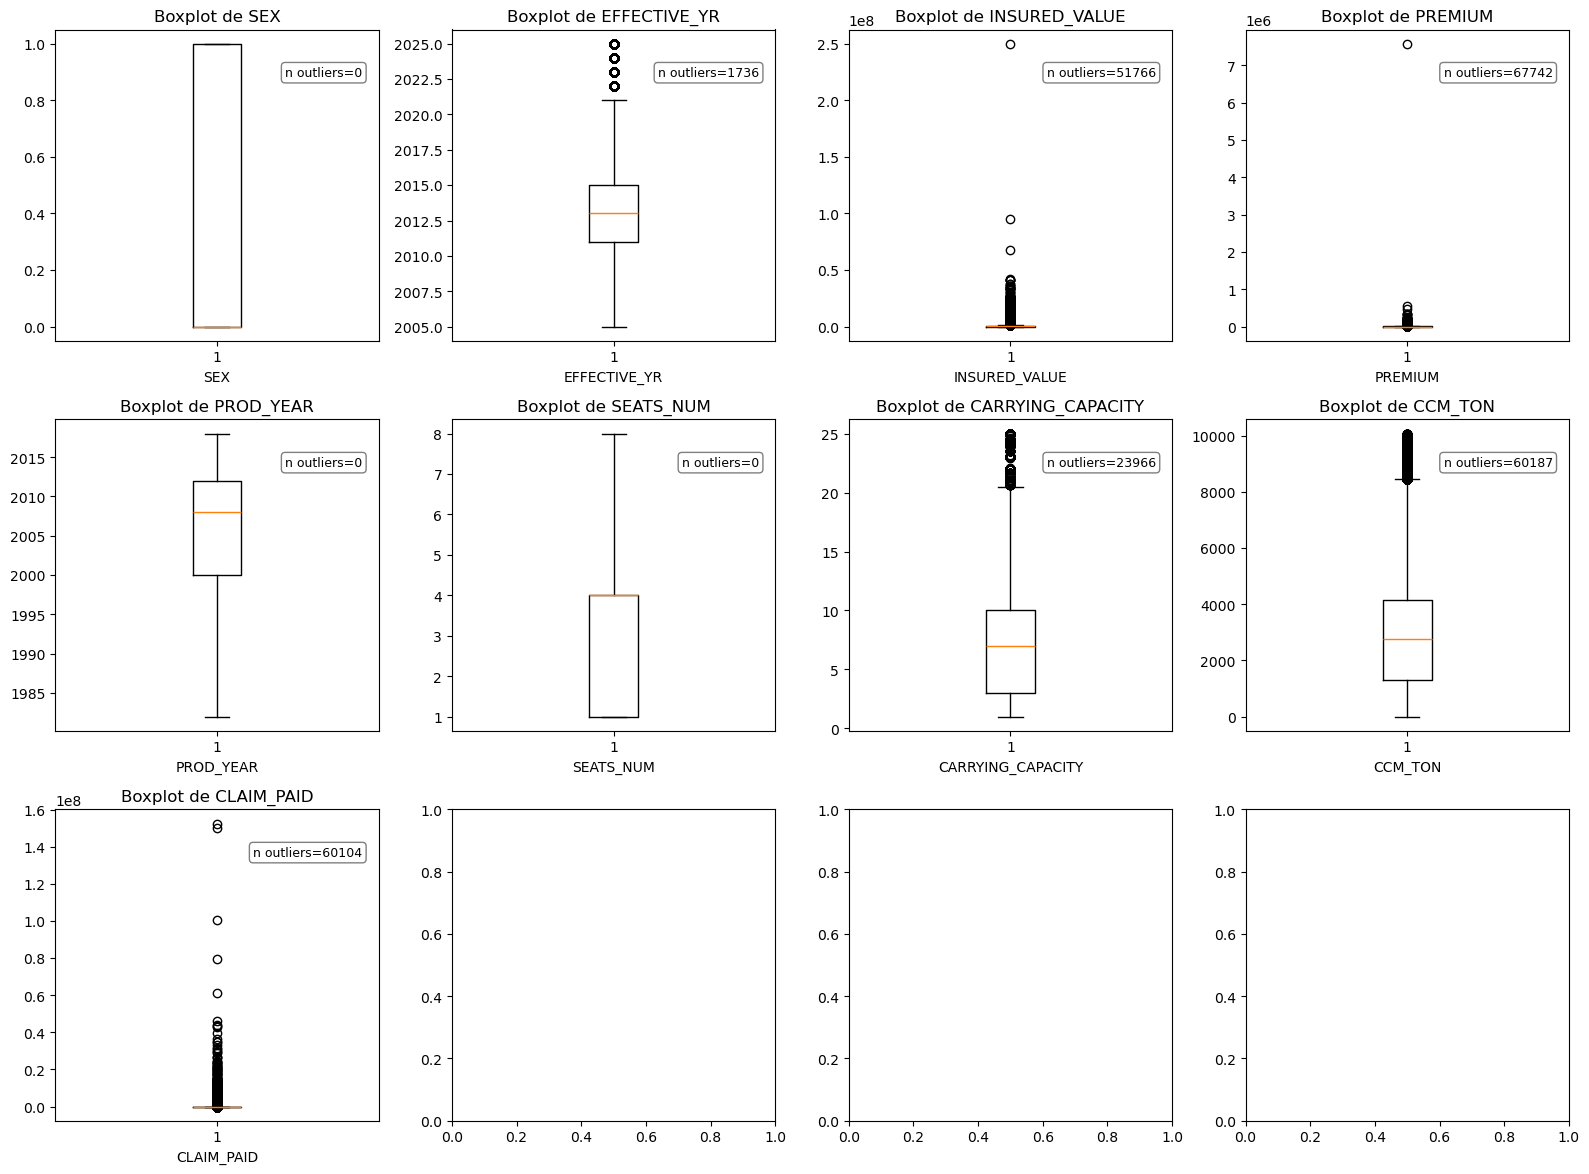

In [15]:
du.listar_outliers_y_boxplot(df, cols_num)

---

### Guardamos el dataframe preprocesado

In [16]:
df.to_csv('../Data/motor_data_2011_2018_pre.csv', index=False)  #
 # se guarda el dataframe 

---

## Detección de outliers con Z-score

In [17]:
from scipy.stats import zscore
import numpy as np

# Variables relevantes para evaluar riesgo
vars_riesgo = ['INSURED_VALUE', 'PREMIUM', 'CLAIM_PAID']

# Cálculo de Z-score absoluto
z_scores = np.abs(zscore(df[vars_riesgo]))

# Umbral clásico de outliers: > 3 desviaciones estándar
outliers = (z_scores > 3).any(axis=1)

# Crear la columna de clasificación de riesgo
df['RISK_CATEGORY'] = 'Normal'
df.loc[outliers, 'RISK_CATEGORY'] = 'Very High'

# Confirmar resultados
print(df['RISK_CATEGORY'].value_counts())

# Asegurar que OBJECT_ID es índice antes de grabar
if 'OBJECT_ID' in df.columns:
    df = df.set_index('OBJECT_ID')

# Guardar el archivo incluyendo el índice correctamente
df.to_csv('../data/motor_data_2011_2018_RISK.csv', index_label='OBJECT_ID')



RISK_CATEGORY
Normal       784801
Very High     17037
Name: count, dtype: int64
